In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
X_train = X_train.iloc[:,1:]
X_test = X_test.iloc[:,1:]
y_train = y_train.iloc[:,1:]
y_test = y_test.iloc[:,1:]

In [3]:
X = np.array(X_train)
y = np.array(y_train)

In [4]:
n = X.shape[0]
# add intercept 
X = np.concatenate((np.array([1]*n).reshape(n,1), X),axis=1)
p = X.shape[1]

## g-prior model

In [5]:
# set prior
nu0 = 1
beta_ols = np.linalg.inv(X.T@X)@X.T@y
SSR_beta_ols = y.T@(np.identity(n)-X@np.linalg.inv(X.T@X)@X.T)@y
sigma_square_ols = SSR_beta_ols/(n-p)
sigma0_square = sigma_square_ols

In [6]:
# posterior sigma_square
g = n
ssr_g = y.T@(np.identity(n)-g/(g+1)*X@np.linalg.inv(X.T@X)@X.T)@y
shape, scale = (nu0+n)/2, 1/((nu0*sigma0_square+ssr_g)/2)[0,0]
sample_size = 5000
np.random.seed(551)
sigma_square = 1/(np.random.gamma(shape, scale, sample_size))

In [7]:
# posterior beta
beta = np.zeros((sample_size,p))
for i in range(sample_size):
    beta[i,:] = np.random.multivariate_normal(mean=g/(g+1)*beta_ols[:,0], 
                                              cov=g/(g+1)*sigma_square[i]*np.linalg.inv(X.T@X), size=1)

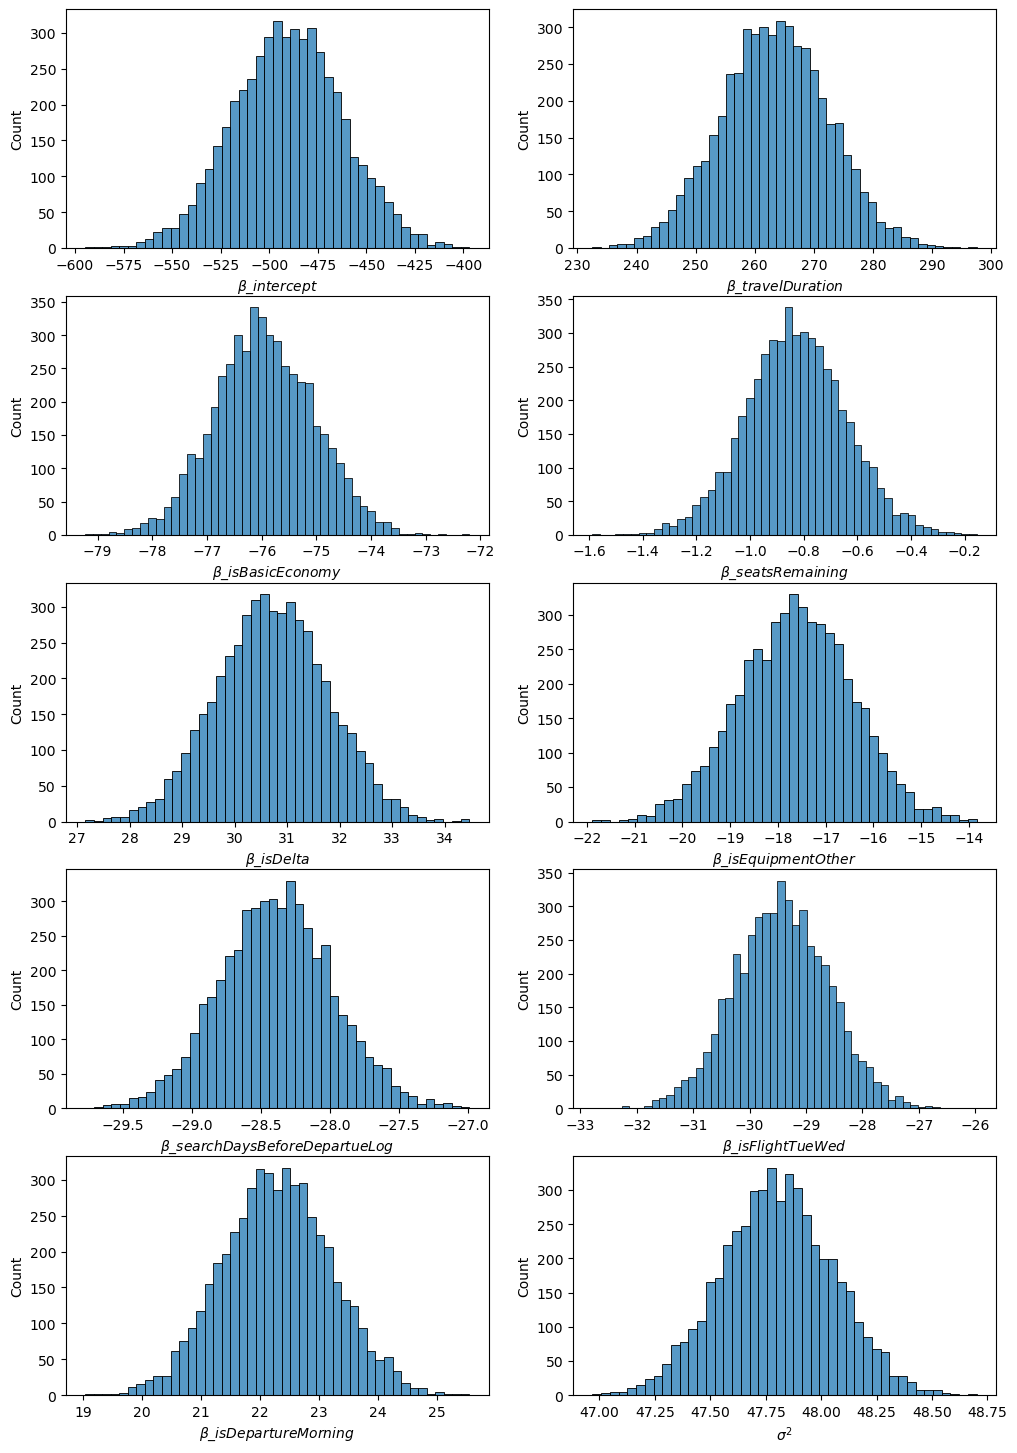

In [8]:
# plot results
colnames = X_train.columns.values
fig, axes = plt.subplots(5,2, figsize=(12,18))
sns.histplot(ax=axes[0,0],x=beta[:,0])
axes[0,0].set(xlabel=r'$\beta \_ intercept$')
sns.histplot(ax=axes[0,1],x=beta[:,1])
axes[0,1].set(xlabel=fr'$\beta \_ {colnames[0]}$')
sns.histplot(ax=axes[1,0],x=beta[:,2])
axes[1,0].set(xlabel=fr'$\beta \_ {colnames[1]}$')
sns.histplot(ax=axes[1,1],x=beta[:,3])
axes[1,1].set(xlabel=fr'$\beta \_ {colnames[2]}$')
sns.histplot(ax=axes[2,0],x=beta[:,4])
axes[2,0].set(xlabel=fr'$\beta \_ {colnames[3]}$')
sns.histplot(ax=axes[2,1],x=beta[:,5])
axes[2,1].set(xlabel=fr'$\beta \_ {colnames[4]}$')
sns.histplot(ax=axes[3,0],x=beta[:,6])
axes[3,0].set(xlabel=fr'$\beta \_ {colnames[5]}$')
sns.histplot(ax=axes[3,1],x=beta[:,7])
axes[3,1].set(xlabel=fr'$\beta \_ {colnames[6]}$')
sns.histplot(ax=axes[4,0],x=beta[:,8])
axes[4,0].set(xlabel=fr'$\beta \_ {colnames[7]}$')
sns.histplot(ax=axes[4,1],x=np.sqrt(sigma_square))
axes[4,1].set(xlabel=r'$\sigma^2$')
#plt.show()
plt.savefig("g-prior posterior parameters.png")

In [9]:
# quantile of parameters
sigma_square_quantile = np.quantile(sigma_square, (0.025,0.975)).reshape(2,1)
beta_quantile = np.quantile(beta,(0.025,0.975),axis=0)
parameter_quantile = np.concatenate((beta_quantile,sigma_square_quantile),axis=1)
parameter = pd.DataFrame({'lower (2.5%) quantile':parameter_quantile[0,:], 
                          'upper (97.5%) quantile': parameter_quantile[1,:]},
                        index = [[r'$\beta \_ intercept$']+[fr'$\beta \_ {name}$' for name in colnames]+
                                 [r'$\sigma^2$']])

In [10]:
parameter

,lower (2.5%) quantile,upper (97.5%) quantile
$\beta \_ intercept$,-544.915776,-435.474790
$\beta \_ travelDuration$,245.762273,281.088510
$\beta \_ isBasicEconomy$,-77.704607,-74.169575
$\beta \_ seatsRemaining$,-1.194689,-0.457058
$\beta \_ isDelta$,28.681333,32.745903
$\beta \_ isEquipmentOther$,-19.981326,-15.331505
$\beta \_ searchDaysBeforeDepartueLog$,-29.194770,-27.576270
$\beta \_ isFlightTueWed$,-31.100357,-27.800628
$\beta \_ isDepartureMorning$,20.521286,24.132331
$\sigma^2$,2238.816736,2331.768467


In [11]:
np.mean(beta,axis=0)

array([-490.29817896,  263.36891533,  -75.95624591,   -0.82976022,
         30.71361737,  -17.62564382,  -28.38660978,  -29.43628193,
         22.28855224])

In [12]:
np.mean(sigma_square)

2285.1359925300153

In [13]:
# make posterior prediction
X_test = np.array(X_test)
n_test= X_test.shape[0]
X_test = np.concatenate((np.array([1]*n_test).reshape(n_test,1), X_test),axis=1)
p_test = X_test.shape[1]

In [14]:
y_test_pred = np.zeros((n_test,100))
for i in range(n_test):
    for j in range(100):
        y_test_pred[i,j] = np.random.multivariate_normal(mean=X_test[i,:]@beta[j:j+1,:].T,
                                                  cov=np.array([[sigma_square[j]]]), size=1)
y_test_pred = np.mean(y_test_pred, axis=1)

In [15]:
# root mean square 
y_test = np.array(y_test)[:,0]
np.sqrt(np.sum((y_test-y_test_pred)**2)/n_test)

48.14112512785145

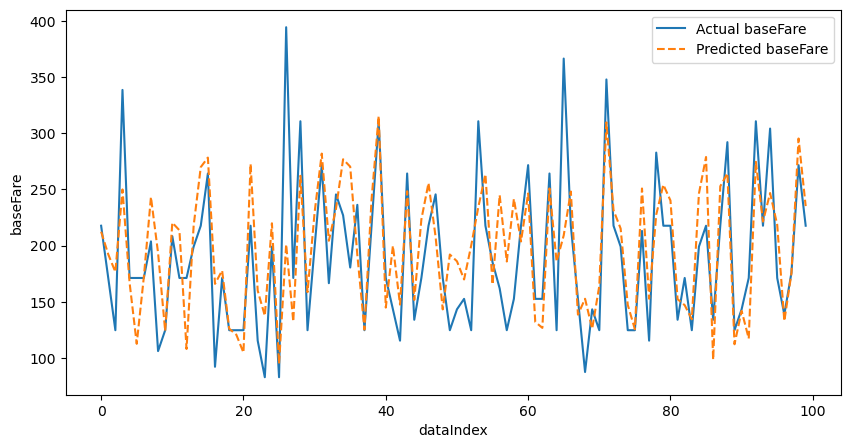

In [16]:
# plot the first 100 data points
plt.figure(figsize=[10,5])
plt.plot(np.arange(100),y_test[:100],label='Actual baseFare')
plt.plot(np.arange(100),y_test_pred[:100],'--',label='Predicted baseFare')
plt.xlabel('dataIndex')
plt.ylabel('baseFare')
plt.legend()
plt.savefig('g-prior predicted basefare')
#plt.show()

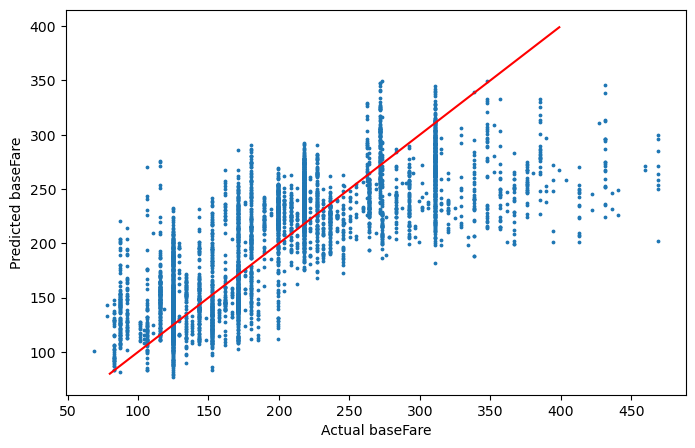

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(y_test,y_test_pred,s=3)
plt.plot(np.arange(80,400),np.arange(80,400),'red')
plt.xlabel('Actual baseFare')
plt.ylabel('Predicted baseFare')
plt.savefig("g-prior predicted basefare.png")
#plt.show()